## Import dataset

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

train_dir = os.path.join("dataset", 'train')

BATCH_SIZE = 2
IMG_SIZE = (160,160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            validation_split=0.2,
                                                            subset="training",
                                                            seed=123,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

val_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                     validation_split=0.2,
                                                     subset="validation",
                                                     seed=123,
                                                     image_size=IMG_SIZE,
                                                     batch_size=BATCH_SIZE)

Found 188 files belonging to 2 classes.
Using 151 files for training.
Found 188 files belonging to 2 classes.
Using 37 files for validation.


In [17]:
class_names = train_dataset.class_names

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

## Creating model base on MobileNetV2

In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [7]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [19]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

Freeze convolutional layer

In [10]:
base_model.trainable = False

Create classifier on top of the pre-trained model

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

In [14]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

## Training

EarlyStopping to stop training when model starts to overfit

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=3, monitor='val_loss')

In [16]:
base_learning_rate = 0.0001
from tensorflow.keras.metrics import *

metrics = ['accuracy']
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=metrics)

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [18]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

19/19 [==============================] - 2s 26ms/step - loss: 0.9618 - accuracy: 0.3514


In [19]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.96
initial accuracy: 0.35


In [20]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[es])

Epoch 1/10
76/76 [==============================] - 5s 38ms/step - loss: 0.8473 - accuracy: 0.5033 - val_loss: 0.7753 - val_accuracy: 0.4865
Epoch 2/10
76/76 [==============================] - 3s 35ms/step - loss: 0.6757 - accuracy: 0.6291 - val_loss: 0.6914 - val_accuracy: 0.5135
Epoch 3/10
76/76 [==============================] - 3s 35ms/step - loss: 0.6194 - accuracy: 0.6225 - val_loss: 0.6193 - val_accuracy: 0.5405
Epoch 4/10
76/76 [==============================] - 3s 35ms/step - loss: 0.5352 - accuracy: 0.6755 - val_loss: 0.5641 - val_accuracy: 0.6757
Epoch 5/10
76/76 [==============================] - 2s 31ms/step - loss: 0.4390 - accuracy: 0.8079 - val_loss: 0.5176 - val_accuracy: 0.7297
Epoch 6/10
76/76 [==============================] - 2s 31ms/step - loss: 0.4617 - accuracy: 0.7682 - val_loss: 0.4704 - val_accuracy: 0.7297
Epoch 7/10
76/76 [==============================] - 2s 31ms/step - loss: 0.4306 - accuracy: 0.7815 - val_loss: 0.4505 - val_accuracy: 0.7297
Epoch 8/10
76

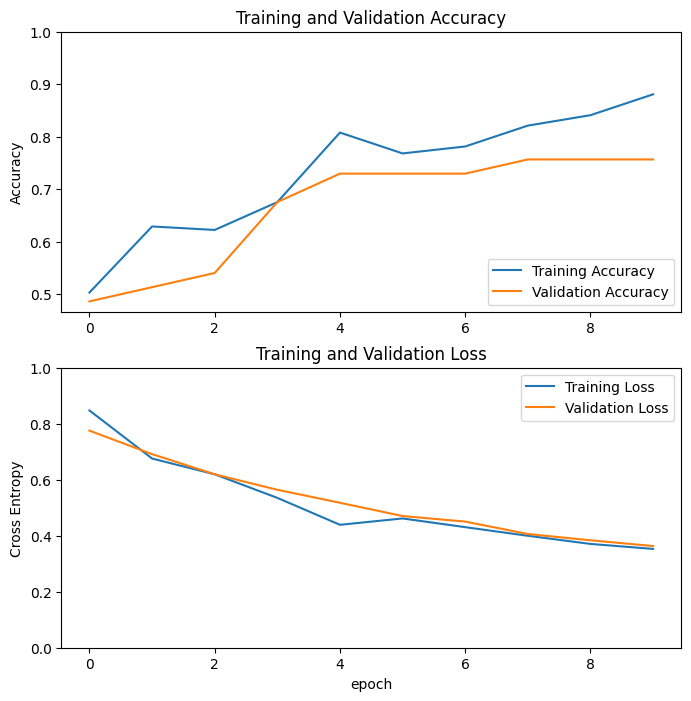

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning

In [22]:
base_model.trainable = True

In [20]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [24]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [26]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=[es])

Epoch 10/20
76/76 [==============================] - 9s 65ms/step - loss: 0.2559 - accuracy: 0.9073 - val_loss: 0.1157 - val_accuracy: 0.9459
Epoch 11/20
76/76 [==============================] - 5s 62ms/step - loss: 0.1510 - accuracy: 0.9338 - val_loss: 0.0831 - val_accuracy: 0.9730
Epoch 12/20
76/76 [==============================] - 5s 59ms/step - loss: 0.0903 - accuracy: 0.9603 - val_loss: 0.0910 - val_accuracy: 0.9459
Epoch 13/20
76/76 [==============================] - 4s 56ms/step - loss: 0.0818 - accuracy: 0.9603 - val_loss: 0.0577 - val_accuracy: 1.0000
Epoch 14/20
76/76 [==============================] - 5s 59ms/step - loss: 0.0661 - accuracy: 0.9735 - val_loss: 0.0923 - val_accuracy: 0.9730
Epoch 15/20
76/76 [==============================] - 5s 59ms/step - loss: 0.0556 - accuracy: 0.9801 - val_loss: 0.0727 - val_accuracy: 0.9730
Epoch 16/20
76/76 [==============================] - 5s 64ms/step - loss: 0.0375 - accuracy: 0.9868 - val_loss: 0.0709 - val_accuracy: 0.9730


In [27]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

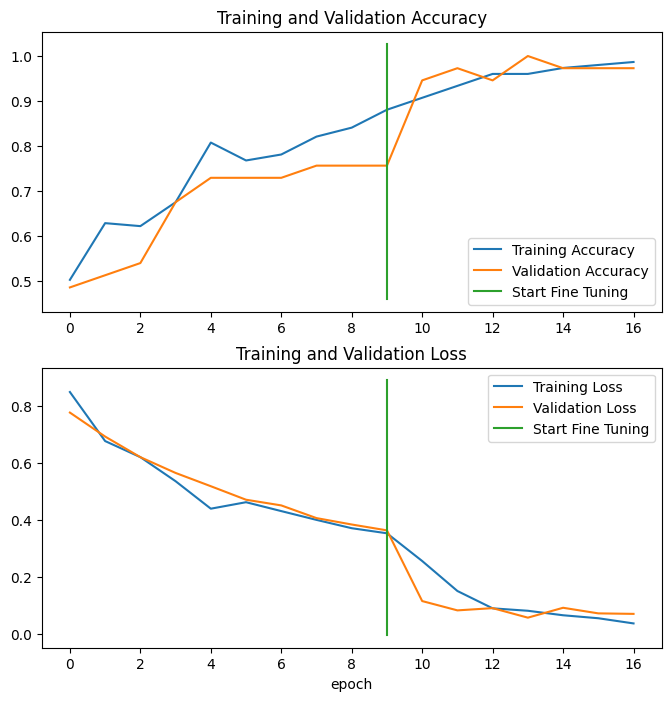

In [28]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Test model with testing set and new data

In [4]:
from classifiers.image_classifier import ImageClassifier

model = ImageClassifier('model')

1/1 [==============================] - 0s 40ms/step


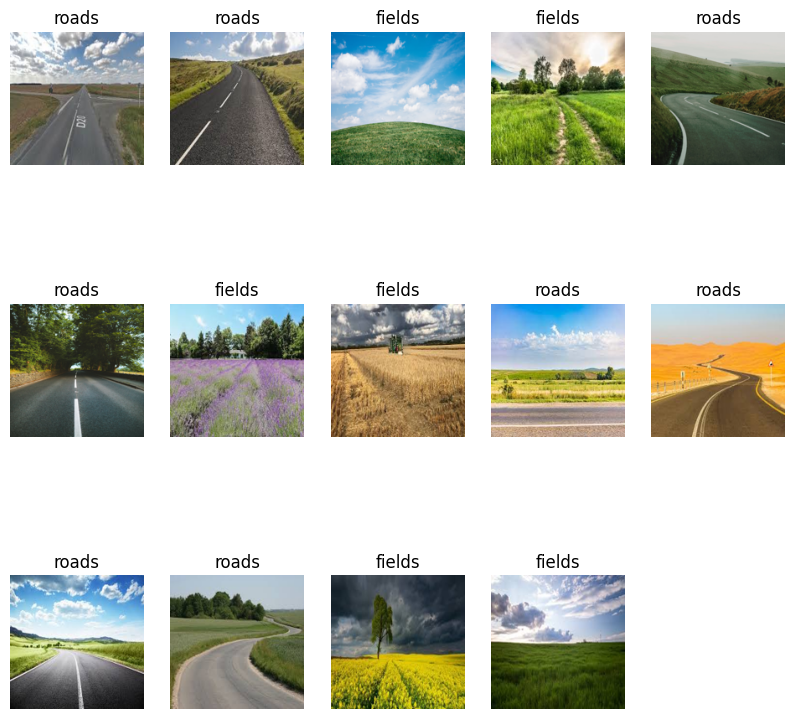

In [12]:
import os
from PIL import Image
import matplotlib.pyplot as plt

test_dir = os.listdir("dataset/test_images/")
plt.figure(figsize=(10, 10))
for i in range(len(test_dir)):
    image = Image.open(os.path.join("dataset/test_images/", test_dir[i]))
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(image.resize((160, 160)))
    plt.title(model.predict_image(image))
    plt.axis("off")
  